<a href="https://colab.research.google.com/github/innosevda/Price-tag-detection-recognition-app/blob/model%2Fpipeline/DocTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install doctr and dependencies
!pip install python-doctr[torch] -q


In [4]:
!pip uninstall protobuf -y


Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3


In [ ]:
!pip install protobuf==3.20.3


In [1]:
!pip install tf2onnx -q


In [2]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

# Test DocTR
print("DocTR is ready to use!")



DocTR is ready to use!


In [3]:
!pip install tf2onnx -q


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


In [8]:
!pip install mplcursors -q


In [3]:

from google.colab import files

# Upload your image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded image file path
print(f"Uploaded image: {image_path}")

Saving 1 (38).jpeg to 1 (38).jpeg
Saving 1 (39).jpeg to 1 (39).jpeg
Saving 1 (40).jpeg to 1 (40).jpeg
Saving 1 (41).jpeg to 1 (41).jpeg
Uploaded image: 1 (38).jpeg


Detected Text:
Turkish
Floss
-
LSTLLILLyE
Net:
Fistiqli
Sada
140
(
70080914.3388
07.07.2024
12:32:44
P
4760019401064
PISHMANIYE
CAN
PA
140GR
FISTIQLI
SADE
KAKAO
3.55AZN
a
4
7
600191/401064
B
A


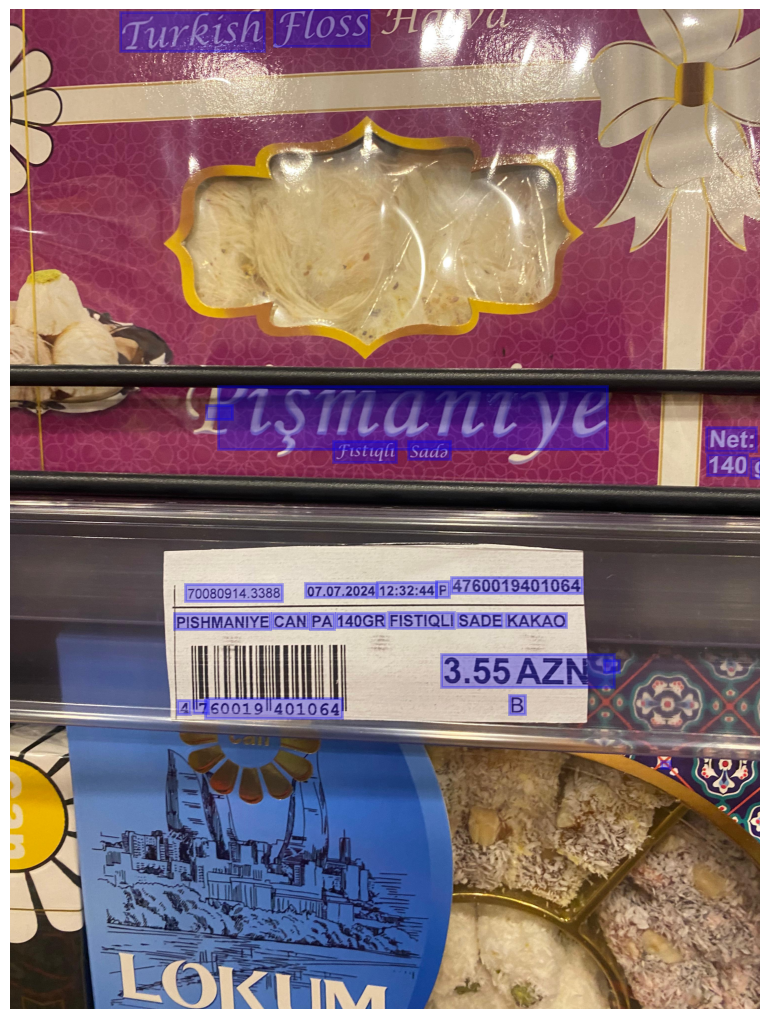

In [9]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import matplotlib.pyplot as plt

# Load the pretrained OCR model
model = ocr_predictor(pretrained=True)

# Path to the uploaded image (replace with your uploaded file's path)
image_path = "/content/1 (38).jpeg"

# Load the image using DocTR
doc = DocumentFile.from_images(image_path)

# Perform OCR
result = model(doc)

# Print the detected text
print("Detected Text:")
for page in result.pages:
    for block in page.blocks:
        for line in block.lines:
            for word in line.words:
                print(word.value)

# Visualize the OCR results
result.show()



In [ ]:
!pip install opencv-python matplotlib pyzbar

In [ ]:
!apt-get install -y libzbar0

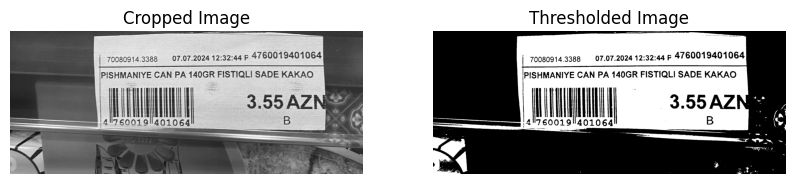

Preprocessed image saved at: preprocessed_image.jpg


In [14]:
import cv2
import numpy as np
from pyzbar.pyzbar import decode
import matplotlib.pyplot as plt
import os

# Function to preprocess an image: barcode cropping, thresholding
def preprocess_image(image_path, output_path, scale_factor=5, threshold_value=150):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return None

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect barcode and locate its bounding box
    barcodes = decode(gray)
    if not barcodes:
        print(f"No barcode found in the image: {image_path}")
        return None

    # Use the first detected barcode
    barcode = barcodes[0]
    (x, y, w, h) = barcode.rect

    # Expand the bounding box for cropping
    expanded_width = int(w * (scale_factor - 1) / 2)
    expanded_height = int(h * (scale_factor - 1) / 2)

    x_min = max(x - expanded_width, 0)
    x_max = min(x + w + expanded_width, image.shape[1])
    y_min = max(y - expanded_height, 0)
    y_max = min(y + h + expanded_height, image.shape[0])

    # Crop the expanded area
    cropped_image = gray[y_min:y_max, x_min:x_max]

    # Apply thresholding
    _, thresholded_image = cv2.threshold(cropped_image, threshold_value, 255, cv2.THRESH_BINARY)

    # Display preprocessing steps
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cropped_image, cmap='gray')
    plt.title("Cropped Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(thresholded_image, cmap='gray')
    plt.title("Thresholded Image")
    plt.axis('off')
    plt.show()

    # Save the preprocessed image
    cv2.imwrite(output_path, thresholded_image)
    print(f"Preprocessed image saved at: {output_path}")
    return output_path

# Preprocess the image and save it
image_path = "/content/1 (38).jpeg"  # Replace with your input image path
output_path = "preprocessed_image.jpg"  # Output image file path
preprocessed_image_path = preprocess_image(image_path, output_path)


Detected Text:
70080914.3388
07.07.2024
12:32:44
P
4760019401064
PISHMANIYE
CAN
PA
140GR
FISTIQLI
SADE
KAKAO
3.55AZN
a
4
7600194010641
B
it
:t


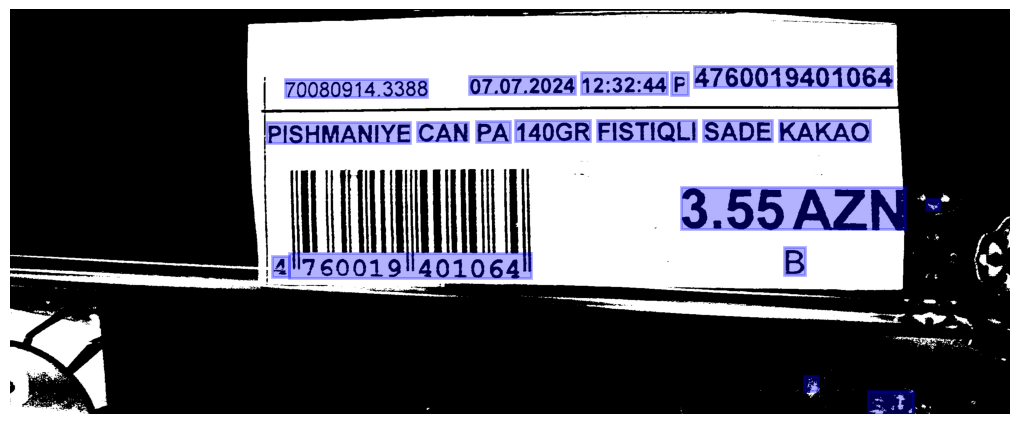

In [15]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

# Load the pretrained OCR model
model = ocr_predictor(pretrained=True)

# Perform OCR using DocTR on the preprocessed image
if preprocessed_image_path:
    doc = DocumentFile.from_images("/content/preprocessed_image.jpg")
    result = model(doc)

    # Print the detected text
    print("Detected Text:")
    for page in result.pages:
        for block in page.blocks:
            for line in block.lines:
                for word in line.words:
                    print(word.value)

    # Visualize the OCR results
    result.show()


Below Did not work as expected


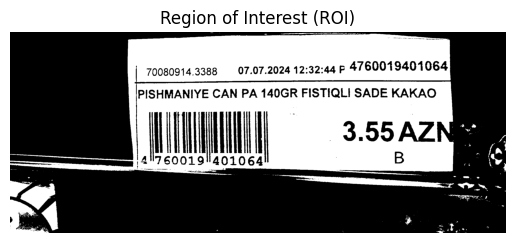

Detected Text: 70080914.3388 07.07.2024 12:32:44 P 4760019401064 PISHMANIYE CAN PA 140GR FISTIQLI SADE KAKAO 3.55AZN a 4 7600194010641 B it :t
Product Name: 70080914.3388
Price: 914.33


In [16]:
import cv2
import numpy as np
from pyzbar.pyzbar import decode
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import re
import matplotlib.pyplot as plt

# Load the pretrained DocTR OCR model
model = ocr_predictor(pretrained=True)

# Function to preprocess and extract price and product name
def process_price_tag(image_path, scale_factor=5, threshold_value=150):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Detect barcode
    barcodes = decode(gray)
    if not barcodes:
        print("No barcode found in the image.")
        return None

    # Use the first detected barcode
    barcode = barcodes[0]
    (x, y, w, h) = barcode.rect

    # Expand the bounding box to include price and product name
    expanded_width = int(w * scale_factor)
    expanded_height = int(h * 2)  # Expand more vertically to include product name
    x_min = max(x - expanded_width, 0)
    x_max = min(x + w + expanded_width, image.shape[1])
    y_min = max(y - expanded_height, 0)
    y_max = min(y + h + expanded_height, image.shape[0])

    # Crop the ROI
    roi = gray[y_min:y_max, x_min:x_max]

    # Apply thresholding
    _, thresholded = cv2.threshold(roi, threshold_value, 255, cv2.THRESH_BINARY)

    # Display the cropped and thresholded region
    plt.imshow(thresholded, cmap='gray')
    plt.title("Region of Interest (ROI)")
    plt.axis('off')
    plt.show()

    # Save the ROI for OCR
    preprocessed_path = "preprocessed_roi.jpg"
    cv2.imwrite(preprocessed_path, thresholded)

    # Step 2: Perform OCR using DocTR
    doc = DocumentFile.from_images(preprocessed_path)
    result = model(doc)

    # Step 3: Extract text
    extracted_text = []
    for page in result.pages:
        for block in page.blocks:
            for line in block.lines:
                text_line = " ".join(word.value for word in line.words)
                extracted_text.append(text_line)

    # Combine all detected text
    full_text = " ".join(extracted_text)
    print("Detected Text:", full_text)

    # Step 4: Extract price using regex
    price_match = re.search(r'\d{1,3}\.\d{2}', full_text)  # Matches patterns like "3.55", "123.45"
    price = price_match.group(0) if price_match else "Price not found"

    # Step 5: (Optional) Extract product name
    product_name = extracted_text[0] if extracted_text else "Product name not found"

    # Display results
    print(f"Product Name: {product_name}")
    print(f"Price: {price}")

    return product_name, price

# Path to your input image
image_path = "/content/preprocessed_image.jpg"  # Use your preprocessed image path

# Process the image to extract price and product name
product_name, price = process_price_tag(image_path, scale_factor=2, threshold_value=150)
